In [83]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
from imutils import contours
import imutils


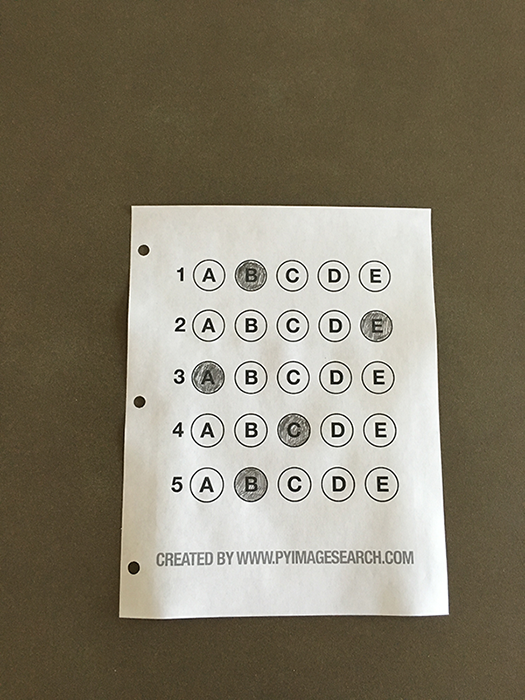

In [84]:
# Membaca gambar lembar jawaban
image = cv2.imread('omr_test_01.png')
cv2_imshow(image)

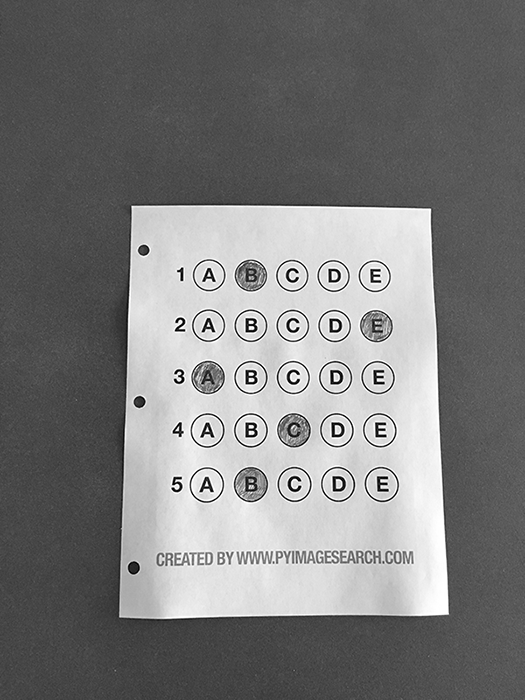

In [85]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

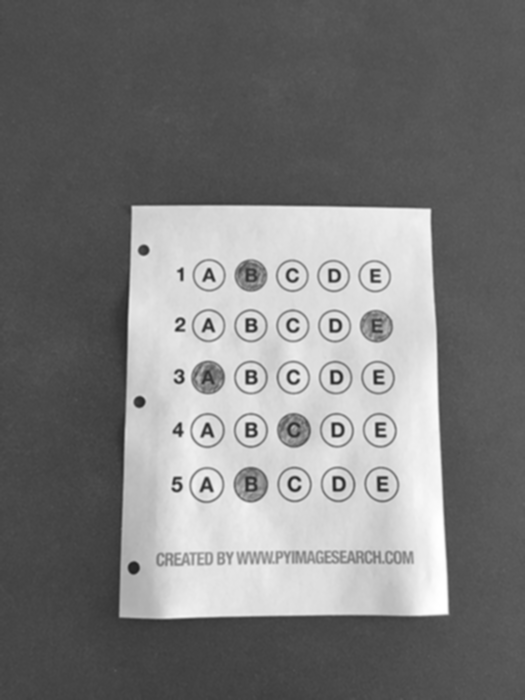

In [86]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
cv2_imshow(blurred)

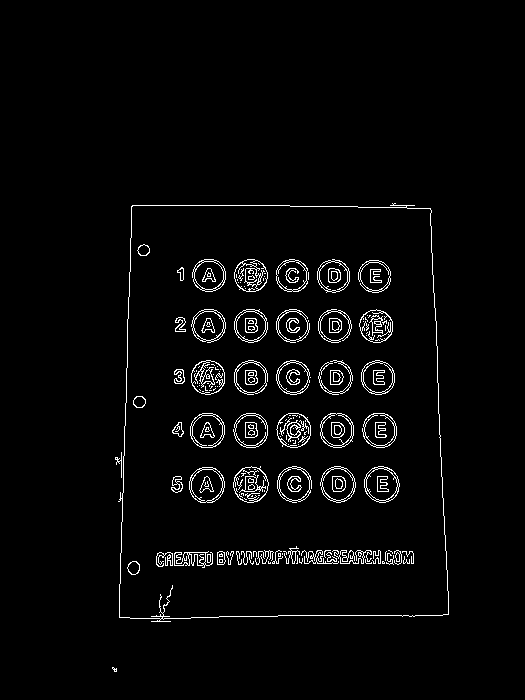

In [88]:
# Menggunakan metode canny edge detection
edged = cv2.Canny(gray, 30, 200)
cv2_imshow(edged)

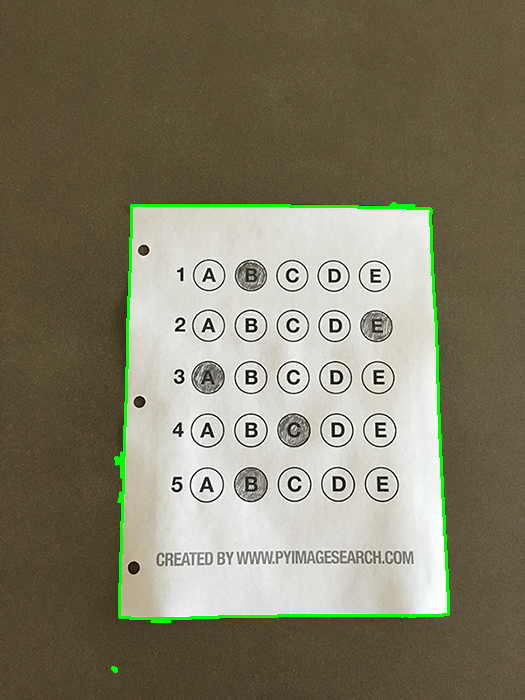

In [89]:
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Menggambar kontur pada gambar asli
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
# Menampilkan gambar dengan OpenCV imshow()
cv2_imshow(image)

In [90]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in
    # descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

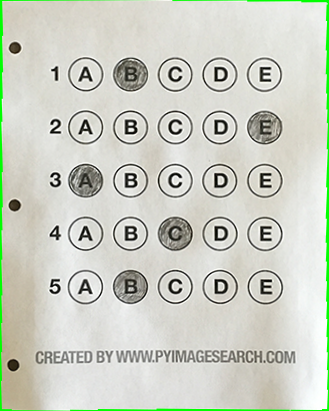

In [91]:
paper = four_point_transform(image, docCnt.reshape(4, 2))
cv2_imshow(paper)

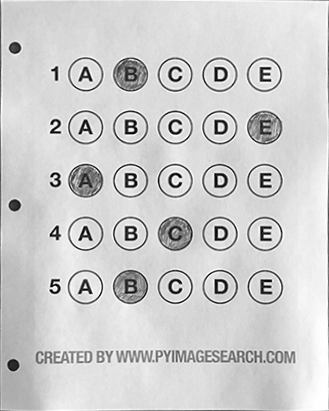

In [92]:
warped = four_point_transform(gray, docCnt.reshape(4, 2))
cv2_imshow(warped)

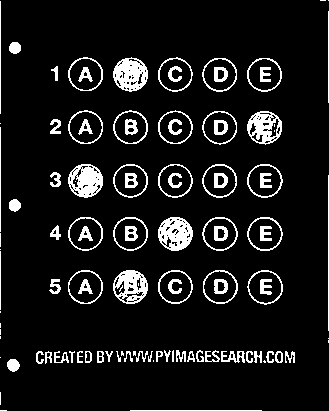

In [93]:
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

Koordinat jawaban siswa: x=247, y=270, w=36, h=35,ar=1.0285714285714285
Koordinat jawaban siswa: x=203, y=270, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=158, y=270, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=113, y=270, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=68, y=270, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=247, y=217, w=36, h=34,ar=1.0588235294117647
Koordinat jawaban siswa: x=202, y=217, w=36, h=34,ar=1.0588235294117647
Koordinat jawaban siswa: x=158, y=217, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=113, y=217, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=68, y=217, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=247, y=164, w=36, h=34,ar=1.0588235294117647
Koordinat jawaban siswa: x=202, y=164, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=158, y=164, w=35, h=34,ar=1.0294117647058822
Koordinat jawaban siswa: x=113, y=164, w=35, h=34,ar=1.02941176470

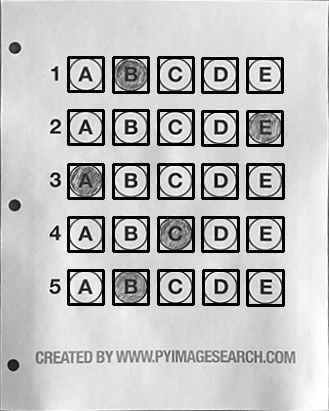

In [105]:
# Mengambil gambar threshold (gambar biner) sebagai input.
# Misalnya, 'thresh' adalah gambar threshold yang telah Anda persiapkan sebelumnya.
# Pastikan gambar tersebut telah dihasilkan melalui proses thresholding yang sesuai.

# Mencari kontur dalam gambar threshold menggunakan fungsi cv2.findContours().
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Mengambil kontur dari hasil cv2.findContours().
cnts = imutils.grab_contours(cnts)

# Inisialisasi daftar kontur yang mewakili pertanyaan.
questionCnts = []

# Melakukan loop pada setiap kontur yang ditemukan.
for c in cnts:
    # Menghitung bounding box dari setiap kontur.
    (x, y, w, h) = cv2.boundingRect(c)

    # Menghitung aspect ratio dari bounding box.
    ar = w / float(h)



    # Memeriksa apakah kontur tersebut memenuhi kriteria untuk menjadi kotak pertanyaan.
    # Kriteria: cukup lebar, cukup tinggi, dan memiliki aspect ratio yang mendekati 1.
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        print("Koordinat jawaban siswa: x={}, y={}, w={}, h={},ar={}".format(x, y, w, h,ar))
        # Menggambar kotak pertanyaan pada gambar asli
        cv2.rectangle(warped, (x, y), (x + w, y + h), (0, 0, 255), 2)
        # Menambahkan kontur yang memenuhi kriteria ke dalam daftar 'questionCnts'.
        questionCnts.append(c)

cv2_imshow(warped)


In [95]:
import pandas as pd
df = pd.read_csv('answer.csv')
ANSWER_KEY = {}
for i in df.values:
    print(i[0], i[1])
    ANSWER_KEY[i[0]] = i[1]

print(ANSWER_KEY)

1 2
2 5
3 1
4 5
5 2
{1: 2, 2: 5, 3: 1, 4: 5, 5: 2}


In [99]:
from imutils import contours
questionCnts = contours.sort_contours(questionCnts,
	method="top-to-bottom")[0]
correct = 0

In [100]:
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    #print(q)
    #print(i)
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None

    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    # initialize the contour color and the index of the
    # *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q+1]
    # check to see if the bubbled answer is correct
    if k == bubbled[1]+1:
        color = (0, 255, 0)
        correct += 1
    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k-1]], -1, color, 3)


[INFO] score: 80.00%


array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [161, 237, 178],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [156, 224, 172],
        ...,
        [135, 249, 136],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [ 15, 248,  18],
        [156, 182, 194],
        ...,
        [255, 255, 255],
        [ 24, 255,  24],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  1, 254,   2],
        [ 20, 246,  24],
        ...,
        [ 16, 255,  16],
        [  1, 255,   1],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]], dtype=uint8)
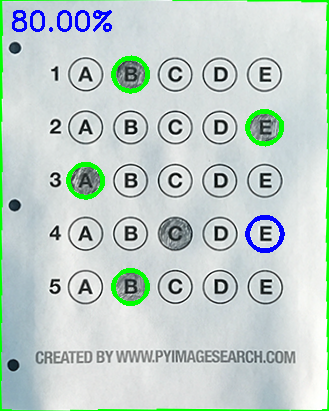

In [101]:
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)